# Facial Expression Recognition Project

## Library Imports

In [0]:
!pip install -U -q PyDrive
!pip install -q keras


from google.colab import files

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from keras.utils import to_categorical

## Helper Functions

In [0]:
def uploadFiles():
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
  filenames = list(uploaded.keys())
  for f in filenames:
    data = str(uploaded[f], 'utf-8')
    file = open(f, 'w')
    file.write(data)
    file.close()

def pullImage(frame, index: int):
  """
  Takes in a pandas data frame object and an index and returns the 48 x 48 pixel
  matrix as well as the label for the type of emotion.
  """
  img = frame.loc[index]['pixels'].split(' ')
  img = np.array([np.int(i) for i in img])
  img.resize(48,48)
  label = np.uint8(frame.loc[index]['emotion'])
  
  return img, label

def splitImage_Labels(frame):
  """
  Takes in a pandas data frame object filled with pixel field and label field 
  and returns two numpy arrays; one for images and one for labels.
  """
  labels = np.empty(len(frame))
  images = np.empty((len(frame), 1, 48, 48))  # using channel first notation.
  
  for i in range(len(frame)):
    images[i][0], labels[i] = pullImage(frame, i)
    
  return images.astype(np.uint8), to_categorical(labels, 7).astype(np.uint8)

## Import FER2013 Dataset and Other Files

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
fer2013 = drive.CreateFile({'id':'1Xdlvej7eXaVcfCf3CsQ1LcSFAiNx_63c'})

In [0]:
fer2013.GetContentFile('fer2013file.csv')

Save file as a pandas dataframe.

In [0]:
df = pd.read_csv('fer2013file.csv')

## Parse Data

Each image is a 48 x 48 grayscale photo.

The contents of pixel string are space-separated pixel values in row major order.

Emotional assignment convention:


*   0 = Angry
*   1 = Disgust
*   2 = Fear
*   3 = Happy
*   4 = Sad
*   5 = Surprise
*   6 = Neutral


In [0]:
df_Training = df[df.Usage == 'Training']
df_Testing = df[df.Usage == 'PrivateTest'].reset_index(drop = True)
img_train, lbl_train = splitImage_Labels(df_Training)
img_test, lbl_test = splitImage_Labels(df_Testing)

In [143]:
print('Type and Shape of Image Datasets: ' + '\n\tTraining: ' + '\t' + 
      str(type(img_train[0][0][0][0])) + '\t' + str(img_train.shape) + 
      '\n\tTesting: ' + '\t' + str(type(img_train[0][0][0][0])) + '\t' + 
      str(img_test.shape))
print('Type and Shape of Image Datasets: ' + '\n\tTraining: ' + '\t' + 
      str(type(lbl_train[0][0])) + '\t' + str(lbl_train.shape) + 
      '\n\tTesting: ' + '\t' + str(type(lbl_train[0][0])) + '\t' + 
      str(lbl_test.shape))

Type and Shape of Image Datasets: 
	Training: 	<class 'numpy.uint8'>	(28709, 1, 48, 48)
	Testing: 	<class 'numpy.uint8'>	(3589, 1, 48, 48)
Type and Shape of Image Datasets: 
	Training: 	<class 'numpy.uint8'>	(28709, 7)
	Testing: 	<class 'numpy.uint8'>	(3589, 7)


### Save Data to .npy Files

In [0]:
np.save('img_train.npy', img_train)
np.save('lbl_train.npy', lbl_train)
np.save('img_test.npy', img_test)
np.save('lbl_test.npy', img_test)

### Verify Image Import

Text(0.5,1,'Training Image 1 (with label [1 0 0 0 0 0 0])')

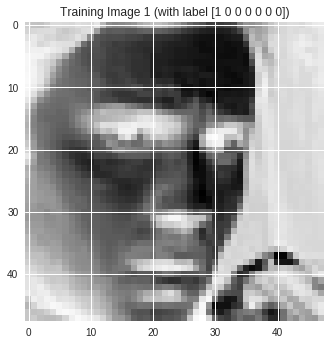

In [144]:
plt.imshow(img_train[0][0])
plt.title('Training Image 1 (with label ' + str(lbl_train[0]) + ')')

Text(0.5,1,'Training Image 1 (with label [1 0 0 0 0 0 0])')

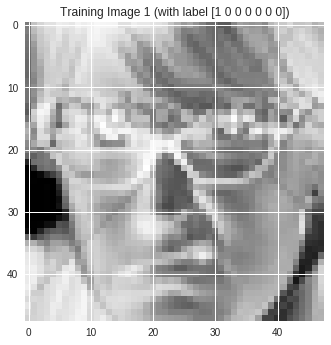

In [145]:
plt.imshow(img_test[0][0])
plt.title('Training Image 1 (with label ' + str(lbl_test[0]) + ')')

## Build Convolutional Neural Network Model

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense
from keras.layers import Activation, Dropout, Flatten

filterSize = 32
kernelSize = 4
strideSize = 3
batchSize = 128
epochs = 50

In [0]:
model = Sequential()
model.add(Conv2D(filterSize, kernelSize, strides = strideSize, padding='same', 
                 data_format='channels_first', activation='relu', 
                 input_shape=img_train[0].shape))
model.add(Conv2D(filterSize, kernelSize, strides = strideSize, padding='same', 
                 data_format='channels_first', activation='relu'))
model.add(Conv2D(filterSize, kernelSize, strides = strideSize, padding='same', 
                 data_format='channels_first', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid',
                       data_format='channels_first'))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


## Train the Model